# CAI Benchmarking

In [1]:
from typing import NamedTuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.simulation import (
    Sim1, Sim1Plus, Sim1Minus, 
    Circuit, CircuitPlus, CircuitMinus,
    MLR, AbstractSimulator
)

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: Dict[str, AbstractSimulator] = {
        "$\Phi^-$": Sim1Minus,
        "$\Phi$": Sim1,
        "$\Phi^+$": Sim1Plus,
        "$\Psi^-$": CircuitMinus,
        "$\Psi$": Circuit,
        "$\Psi^+$": CircuitPlus,
    }
    run_names: list = None
    suffix: str = "_cai_benchmarking"

conf = Config()

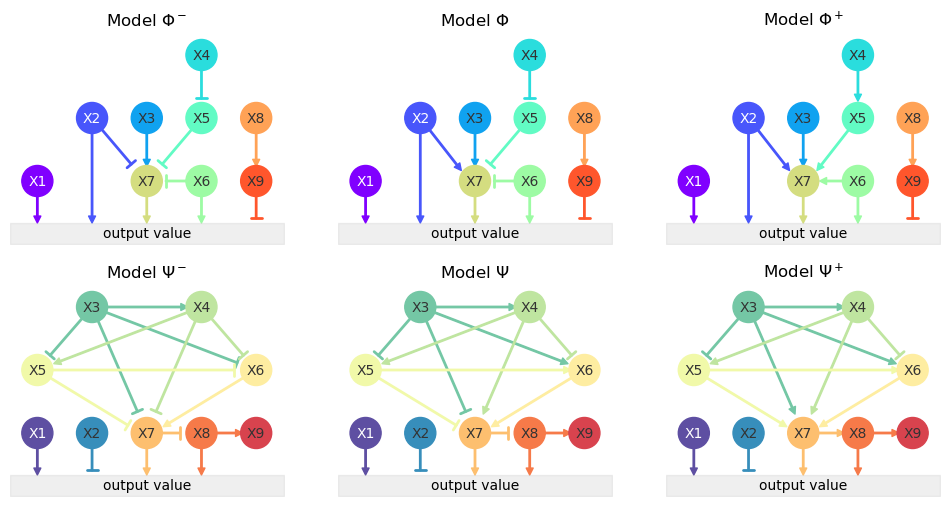

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (key, model), a in zip(conf.simulator.items(), ax.ravel()):
    model().plot(ax=a)
    a.set_title(model().name)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

In [4]:
noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=.5)),
    dict(kwarg_err=dict(loc=0, scale=1)),
    dict(kwarg_err=dict(loc=0, scale=2)),
]

noise_names = [
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,0.5)$",
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,1)$",
    r"$\varepsilon_{i,j},\varepsilon_{y,j}\sim\mathcal{N}(0,2)$"
]

conditions = dict(
    ff=list(map(lambda x: x(), list(conf.simulator.values()) * len(noise_conf))),
    pb=list(map(lambda x: x(), list(conf.simulator.values()) * len(noise_conf))),
    cloo=list(map(lambda x: x(), list(conf.simulator.values()) * len(noise_conf))),
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [5]:
for k, models in conditions.items():
    [
        m.simulate(
            design=designs[k],
            n_rep=3,
            model_kwargs=noise_conf[i // len(conf.simulator)],
        ) for i, m in enumerate(models)
    ]

In [6]:
ground_truth = [
    MLR(ff).summary(anova=True, dtype=int) for i, ff in enumerate(conditions["ff"])
]

pb_k, cloo_k = [], []

kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for pb, cloo, gt in zip(conditions["pb"], conditions["cloo"], ground_truth):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]

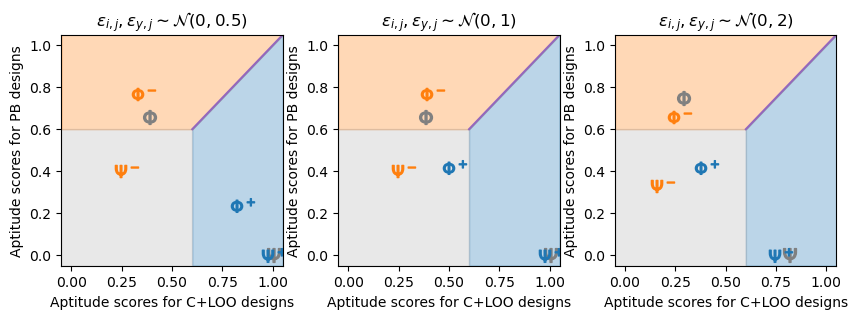

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
plt.subplots_adjust(wspace=.25)

df = pd.DataFrame({
    "err": np.ravel([[v] * len(conf.simulator) for v in [.5, 1, 2]]),
    "pb_k": pb_k,
    "cloo_k": cloo_k,
    "model": list(conf.simulator.keys()) * 3,
})

for i, a in enumerate(ax.ravel()):
    dat = df[df.err == df.err.unique()[i]]
    a.fill_between([-.05, .6, 1.05], [.6, .6, 1.05], 1.05, color="C1", alpha=.3)
    a.fill_between([.6, 1.05], [.6, 1.05], -.05, color="C0", alpha=.3)
    a.fill_between([-.05, .6], [.6, .6], -.05, color=".7", alpha=.3)
    a.plot([.6, 1.05], [.6, 1.05], c="C4")
    for row in range(len(dat)):
        marker = dat.model.iloc[row]
        s = 100 if "^" not in dat.model.iloc[row] else 300
        c = (["C1", ".5", "C0"] * 2)[row]
        a.scatter(
            dat.cloo_k.iloc[row], dat.pb_k.iloc[row], marker=marker, 
            s=s, c=c
        )
        a.set(title=noise_names[i], xlabel="Aptitude scores for C+LOO designs", ylabel="Aptitude scores for PB designs")
        a.set_xlim(-.05, 1.05), a.set_ylim(-.05, 1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa{conf.suffix}", **kwarg_savefig)

In [8]:
maxrd, cov, effpos, cai = {}, {}, {}, {}

ap = lambda c: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, connectionstyle="arc3",
    facecolor=c, edgecolor=c,
)

ap2 = lambda c: dict(
    arrowstyle="|-|", connectionstyle="arc3",
    facecolor=c, edgecolor=c,
    linewidth=2, mutation_scale=4,
)

arrconf=dict(ha="center", va="center", zorder=-10)

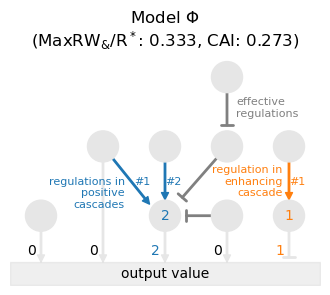

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 5, 7, 7, 7, 5, 9, 9],
    "v": [3, 6, 6, 9, 6, 3, 3, 6, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1], [3, 6], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [4.5, 3.5], [3, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5, 3.7], [5, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [7, 6.8], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.5, 3.7], [7, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.6, 3], [7, 3], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [9, 3.7], [9, 6], arrowprops=ap("C1"), **arrconf)
ax.annotate("", [9, 1.1], [9, 3], arrowprops=ap2(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[6], datdot.v[6], 2, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[8], datdot.v[8], 1, ha="center", va="center", size=10, c="C1")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 2, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[5] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[8] - .3, 1.5, 1, ha="center", va="center", size=10, c="C1")

ax.text(4, 4.5, "#1", ha="left", va="center", size=8, c="C0")
ax.text(5, 4.5, "#2", ha="left", va="center", size=8, c="C0")
ax.text(9, 4.5, "#1", ha="left", va="center", size=8, c="C1")


ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
ax.text(3.7, 4, "regulations in\npositive\ncascades", ha="right", va="center", c="C0", size=8)
ax.text(8.8, 4.5, "regulation in\nenhancing\ncascade", ha="right", va="center", c="C1", size=8)
ax.text(7.3, 7.7, "effective\nregulations", ha="left", va="center", c=".5", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Phi$"

maxrd[name], cov[name], effpos[name] = 2/6, 6/36, 3/6
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/sim1_maxrd&", **kwarg_savefig)

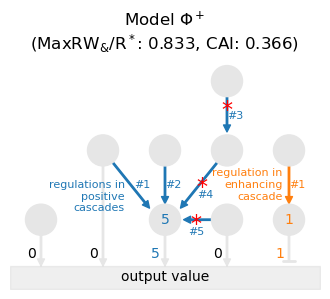

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 5, 7, 7, 7, 5, 9, 9],
    "v": [3, 6, 6, 9, 6, 3, 3, 6, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1], [3, 6], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [4.5, 3.5], [3, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5, 3.7], [5, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [7, 6.8], [7, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5.5, 3.5], [7, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5.6, 3], [7, 3], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [9, 3.7], [9, 6], arrowprops=ap("C1"), **arrconf)
ax.annotate("", [9, 1.1], [9, 3], arrowprops=ap2(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[6], datdot.v[6], 5, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[8], datdot.v[8], 1, ha="center", va="center", size=10, c="C1")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 5, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[5] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[8] - .3, 1.5, 1, ha="center", va="center", size=10, c="C1")

ax.text(4, 4.5, "#1", ha="left", va="center", size=8, c="C0")
ax.text(5, 4.5, "#2", ha="left", va="center", size=8, c="C0")
ax.text(7, 7.5, "#3", ha="left", va="center", size=8, c="C0")
ax.text(6.3, 4.3, "#4", ha="center", va="top", size=8, c="C0")
ax.text(6, 2.7, "#5", ha="center", va="top", size=8, c="C0")
ax.text(9, 4.5, "#1", ha="left", va="center", size=8, c="C1")

ax.text(7, 7.8, "$*$", ha="center", va="center", size=16, c="r")
ax.text(6.2, 4.5, "$*$", ha="center", va="center", size=16, c="r")
ax.text(6, 2.9, "$*$", ha="center", va="center", size=16, c="r")


ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
ax.text(3.7, 4, "regulations in\npositive\ncascades", ha="right", va="center", c="C0", size=8)
ax.text(8.8, 4.5, "regulation in\nenhancing\ncascade", ha="right", va="center", c="C1", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Phi^+$"

maxrd[name], cov[name], effpos[name] = 5/6, 6/36, 6/6
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/sim1+_maxrd&", **kwarg_savefig)

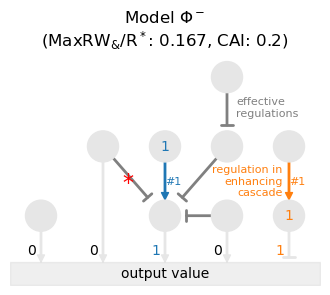

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 5, 7, 7, 7, 5, 9, 9],
    "v": [3, 6, 6, 9, 6, 3, 3, 6, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})

[5, 3.7], [5, 6]

ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1], [3, 6], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [4.5, 3.7], [3, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5, 3.7], [5, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [7, 6.8], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.5, 3.7], [7, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.6, 3], [7, 3], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [9, 3.7], [9, 6], arrowprops=ap("C1"), **arrconf)
ax.annotate("", [9, 1.1], [9, 3], arrowprops=ap2(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[2], datdot.v[2], 1, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[8], datdot.v[8], 1, ha="center", va="center", size=10, c="C1")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 1, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[5] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[8] - .3, 1.5, 1, ha="center", va="center", size=10, c="C1")

ax.text(3.8, 4.5, "$*$", ha="center", va="center", size=16, c="r")
# ax.text(5, 4.5, "$*$", ha="center", va="center", size=16, c="r")
ax.text(5, 4.5, "#1", ha="left", va="center", size=8, c="C0")
ax.text(9, 4.5, "#1", ha="left", va="center", size=8, c="C1")


ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
# ax.text(3.7, 4, "regulations in\npositive\ncascades", ha="right", va="center", c="C0", size=8)
ax.text(8.8, 4.5, "regulation in\nenhancing\ncascade", ha="right", va="center", c="C1", size=8)
ax.text(7.3, 7.7, "effective\nregulations", ha="left", va="center", c=".5", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Phi^-$"

maxrd[name], cov[name], effpos[name] = 1/6, 6/36, 2/6
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/sim1-_maxrd&", **kwarg_savefig)

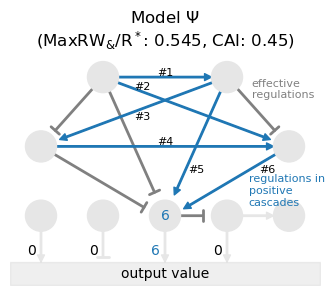

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 3, 7, 1, 9, 5, 7, 9],
    "v": [3, 3, 9, 9, 6, 6, 3, 3, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1.1], [3, 3], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [6.5, 9], [3, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [1.4, 6.6], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [8.4, 6.3], [3, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [4.7, 3.9], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [1.6, 6.3], [7, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [8.6, 6.6], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.3, 3.9], [7, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [8.5, 6], [1, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [4.4, 3.3], [1, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.6, 3.3], [9, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [6.3, 3], [5, 3], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [8.5, 3], [7, 3], arrowprops=ap(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[6], datdot.v[6], 6, ha="center", va="center", size=10, c="C0")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 6, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[7] - .3, 1.5, 0, ha="center", va="center", size=10)

ax.text(5, 9, "#1", ha="center", va="bottom", size=8)
ax.text(4, 8.6, "#2", ha="left", va="center", size=8)
ax.text(4, 7.5, "#3", ha="left", va="top", size=8)
ax.text(5, 6, "#4", ha="center", va="bottom", size=8)
ax.text(8.3, 5, "#6", ha="center", va="center", size=8)
ax.text(6, 5, "#5", ha="center", va="center", size=8)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
ax.text(7.7, 4.1, "regulations in\npositive\ncascades", ha="left", va="center", c="C0", size=8)
ax.text(7.8, 8.5, "effective\nregulations", ha="left", va="center", c=".5", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Psi$"

maxrd[name], cov[name], effpos[name] = 6/11, 12/36, 6/11
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/circuit_maxrd&", **kwarg_savefig)

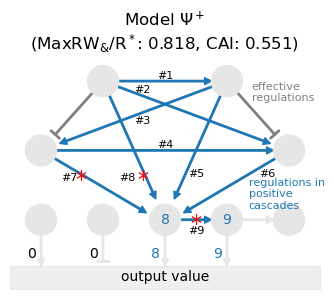

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 3, 7, 1, 9, 5, 7, 9],
    "v": [3, 3, 9, 9, 6, 6, 3, 3, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1.1], [3, 3], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [6.5, 9], [3, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [1.4, 6.6], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [8.4, 6.3], [3, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [4.7, 3.9], [3, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [1.6, 6.3], [7, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [8.6, 6.6], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.3, 3.9], [7, 9], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [8.5, 6], [1, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [4.4, 3.3], [1, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5.6, 3.3], [9, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [6.5, 3], [5, 3], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [8.5, 3], [7, 3], arrowprops=ap(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[6], datdot.v[6], 8, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[7], datdot.v[7], 9, ha="center", va="center", size=10, c="C0")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 8, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[7] - .3, 1.5, 9, ha="center", va="center", size=10, c="C0")

ax.text(5, 9, "#1", ha="center", va="bottom", size=8)
ax.text(4, 8.6, "#2", ha="left", va="center", size=8)
ax.text(4, 7.5, "#3", ha="left", va="top", size=8)
ax.text(5, 6, "#4", ha="center", va="bottom", size=8)
ax.text(8.3, 5, "#6", ha="center", va="center", size=8)
ax.text(6, 5, "#5", ha="center", va="center", size=8)
ax.text(3.8, 4.8, "#8", ha="center", va="center", size=8)
ax.text(1.9, 4.8, "#7", ha="center", va="center", size=8)
ax.text(6, 2.5, "#9", ha="center", va="center", size=8)

ax.text(4.3, 4.8, "$*$", ha="center", va="center", size=16, c="r")
ax.text(2.3, 4.8, "$*$", ha="center", va="center", size=16, c="r")
ax.text(6, 2.9, "$*$", ha="center", va="center", size=16, c="r")

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
ax.text(7.7, 4.1, "regulations in\npositive\ncascades", ha="left", va="center", c="C0", size=8)
# ax.text(8.7, 4.5, "enhancing\nregulation", ha="right", va="center", c="C1", size=8)
ax.text(7.8, 8.5, "effective\nregulations", ha="left", va="center", c=".5", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Psi^+$"

maxrd[name], cov[name], effpos[name] = 9/11, 12/36, 9/11
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/circuit+_maxrd&", **kwarg_savefig)

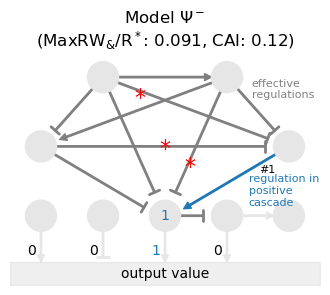

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 3, 7, 1, 9, 5, 7, 9],
    "v": [3, 3, 9, 9, 6, 6, 3, 3, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1.1], [3, 3], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [6.5, 9], [3, 9], arrowprops=ap(".5"), **arrconf)
ax.annotate("", [1.4, 6.6], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [8.4, 6.3], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [4.7, 3.9], [3, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [1.6, 6.3], [7, 9], arrowprops=ap(".5"), **arrconf)
ax.annotate("", [8.6, 6.6], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.3, 3.9], [7, 9], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [8.3, 6], [1, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [4.4, 3.3], [1, 6], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [5.6, 3.3], [9, 6], arrowprops=ap("C0"), **arrconf)
ax.annotate("", [5, 1], [5, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [6.3, 3], [5, 3], arrowprops=ap2(".5"), **arrconf)
ax.annotate("", [7, 1], [7, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [8.5, 3], [7, 3], arrowprops=ap(".9"), **arrconf)

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[6], datdot.v[6], 1, ha="center", va="center", size=10, c="C0")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[6] - .3, 1.5, 1, ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[7] - .3, 1.5, 0, ha="center", va="center", size=10)


ax.text(5, 6, "$*$", ha="center", va="center", size=16, c="r")
ax.text(8.3, 5, "#1", ha="center", va="center", size=8)

ax.text(4, 8.6, "*", ha="left", va="top", size=16, c="r")
ax.text(5.8, 5.2, "$*$", ha="center", va="center", size=16, c="r")

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")
ax.text(7.7, 4.1, "regulation in\npositive\ncascade", ha="left", va="center", c="C0", size=8)
# ax.text(8.7, 4.5, "enhancing\nregulation", ha="right", va="center", c="C1", size=8)
ax.text(7.8, 8.5, "effective\nregulations", ha="left", va="center", c=".5", size=8)

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

name = "$\Psi^-$"

maxrd[name], cov[name], effpos[name] = 1/11, 12/36, 1/11
cai[name] = harmonic_mean(maxrd[name], cov[name], effpos[name])

ax.set_title(f"Model {name}\n(MaxRW$_&$/R$^*$: {round(maxrd[name], 3)}, CAI: {round(cai[name], 3)})")

if conf.savefig:
    fig.savefig(f"{conf.out}/circuit-_maxrd&", **kwarg_savefig)

In [15]:
df_metrics = pd.DataFrame({
    "model": conf.simulator.keys(),
    "cloo_k": df[df.err == 1].cloo_k.values,
    "pb_k": df[df.err == 1].pb_k.values,
    "MaxRW$_&$/R$^*$": [maxrd[key] for key in conf.simulator.keys()],
    "CAI": [cai[key] for key in conf.simulator.keys()]
})

df_metrics_stack = pd.DataFrame({
    "model": np.ravel([list(map(lambda x: f"Model {x}", [key] * 4)) for key in conf.simulator]),
    "base": np.ravel([list(map(lambda x: 0 if "Phi" in x else 1, [key] * 4)) for key in conf.simulator]),
    "scores": np.ravel([[maxrd[key], cov[key], effpos[key], cai[key]] for key in conf.simulator]),
    "": np.ravel([["MaxRW$_&$/R$^*$", "R%", "R$^*_{(+)}$/R$^*$", "CAI"] for _ in conf.simulator]),
})

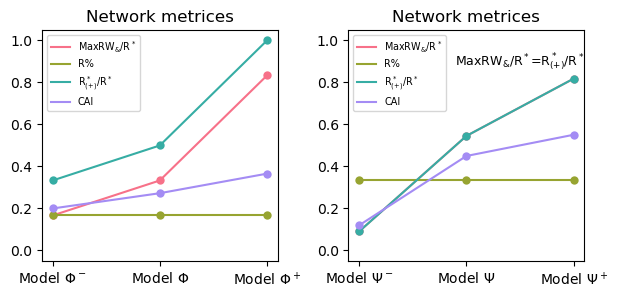

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.3)

for i, a in enumerate(ax.ravel()):
    sns.lineplot(
        data=df_metrics_stack[df_metrics_stack.base == i], 
        x="model", y="scores", hue="",
        marker="o", palette="husl",
        ax=a, 
        markeredgewidth=0,
    )
    
    a.set_ylim(-0.05, 1.05)
    a.set(title="Network metrices", xlabel="", ylabel="")
    a.legend(fontsize="x-small")
    
    if i == 1:
        a.text(1.5, .9, "MaxRW$_&$/R$^*$=R$^*_{(+)}$/R$^*$", ha="center", va="center", size=9)

if conf.savefig:
    fig.savefig(f"{conf.out}/metrices_{conf.suffix}", **kwarg_savefig)

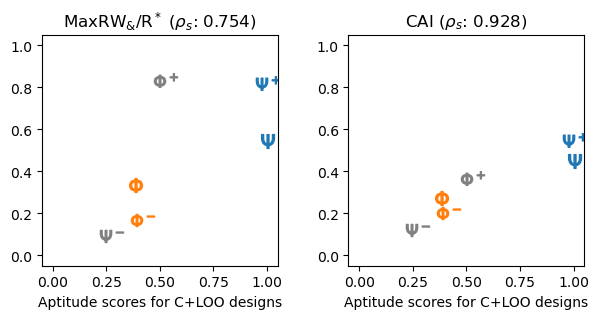

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.3)

for key, a in zip(["MaxRW$_&$/R$^*$", "CAI"], ax.ravel()):
    for row in range(len(dat)):
        marker = df_metrics.model.iloc[row]
        s = 100 if "^" not in marker else 300
        c = {
            i: k for i, k in enumerate([".5", "C0", "C1", "C4"])
        }[int(df_metrics.cloo_k[row] > .6) + 2 * int(df_metrics.pb_k[row] > .6)]
        corr = df_metrics.loc[:, ["cloo_k", key]].corr(method="spearman")["cloo_k"][key].round(3)
        a.scatter(
            df_metrics.cloo_k[row], 
            df_metrics.loc[:, key][row], 
            marker=marker, s=s, c=c
        )
        a.set(title=f"{key} "+r"($\rho_s$: "+f"{corr})", xlabel="Aptitude scores for C+LOO designs")
        a.set_xlim(-.05, 1.05), a.set_ylim(-.05, 1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/maxrd_vs_cai{conf.suffix}", **kwarg_savefig)

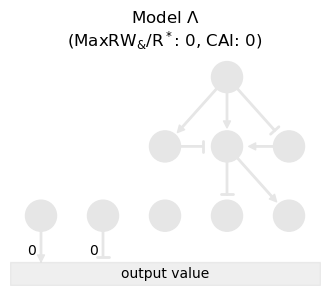

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

datdot = pd.DataFrame({
    "name": [f"X{i + 1}" for i in range(9)],
    "h": [1, 3, 5, 7, 5, 9, 7, 7, 9],
    "v": [3, 3, 3, 9, 6, 6, 6, 3, 3],
    "c": [".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9", ".9",]
})


ax.annotate("", [1, 1], [1, 3], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [3, 1.1], [3, 3], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [5.4, 6.6], [7, 9], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [8.6, 6.6], [7, 9], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [7, 6.8], [7, 9], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [6.3, 6], [5, 6], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [7.7, 6], [9, 6], arrowprops=ap(".9"), **arrconf)
ax.annotate("", [7, 3.8], [7, 6], arrowprops=ap2(".9"), **arrconf)
ax.annotate("", [8.6, 3.6], [7, 6], arrowprops=ap(".9"), **arrconf)


ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.text(datdot.h[0] - .3, 1.5, 0, ha="center", va="center", size=10)
ax.text(datdot.h[1] - .3, 1.5, 0, ha="center", va="center", size=10)


ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("Model $\Lambda$\n(MaxRW$_&$/R$^*$: 0, CAI: 0)")

if conf.savefig:
    fig.savefig(f"{conf.out}/sparse_maxrd&", **kwarg_savefig)